In [195]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
import pyLDAvis.gensim
from gensim.models import LdaMulticore
import pyLDAvis.gensim

In [241]:
df = pd.read_csv("D:/Datasets/stream_tweets/df_finale_true_cluster.csv")

In [197]:
clu1 = pd.read_csv("D:/Datasets/stream_tweets/ment_clu1.csv")
clu2 = pd.read_csv("D:/Datasets/stream_tweets/ment_clu2.csv")
clu3 = pd.read_csv("D:/Datasets/stream_tweets/ment_clu3.csv")
clu4 = pd.read_csv("D:/Datasets/stream_tweets/ment_clu4.csv")
clu5 = pd.read_csv("D:/Datasets/stream_tweets/ment_clu5.csv")

# Distribuzione cluster

In [242]:
df.rename(columns = {"cluster_y":"cluster"}, inplace = True)

In [243]:
num_cluster = df.groupby("cluster").count().sort_values(by = "Unnamed: 0", ascending = False).reset_index()[["cluster","Unnamed: 0"]]
num_cluster["Unnamed: 0"].mean()

1188.25

In [200]:
dit = pd.read_csv("C:/Users/loren/Downloads/result_mention.csv")

In [201]:
chek = dit[dit["cluster_y"] == 3]

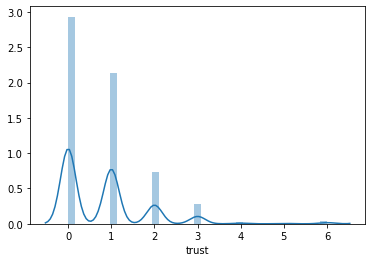

In [202]:
import seaborn as sns 
sns.distplot(chek.trust)

In [127]:
import numpy as np
import pandas as pd
outliers=[]
which_outlier = []
def detect_outlier(data_1):
    
    threshold= 2
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
            which_outlier.append(z_score)
    return outliers, which_outlier

In [128]:
outliers, which_outlier = detect_outlier(chek.trust)

# Preproccesing text

In [203]:
import re
def remove_link(x):
    x = re.sub(r"http\S+", "", x)
    return x

In [204]:
def remove_emoji(x):
    x = re.sub(r"(\<u+\S*>)", "", x)
    return x

In [205]:
df["text"] = df.text.str.lower()
df.text = df.text.apply(remove_emoji)
df["text"] = df.text.apply(remove_link)
df.text = df.text.replace("#\w+","", regex = True) #rimozione hashtags
df.text = df.text.replace("@[^\s:]+", "", regex = True) #rimozione mentions
#df.text = df.text.replace("#","", regex = True)
#df.text = df.text.replace("@", "", regex = True)
df.text = df.text.replace("\n", " ", regex = True)
df.text = df.text.replace("-", "", regex = True)
df.text = df.text.replace('[^\w\s]', ' ', regex = True)
df.text = df.text.replace("_", "", regex = True) 
df.text = df.text.replace("\d*","",regex = True)
df.text = df.text.replace('\s+', ' ', regex=True) #rimuovere più spazi bianchi

<>:4: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \s
<>:10: DeprecationWarning: invalid escape sequence \w
<>:12: DeprecationWarning: invalid escape sequence \d
<>:13: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \s
<>:10: DeprecationWarning: invalid escape sequence \w
<>:12: DeprecationWarning: invalid escape sequence \d
<>:13: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \s
<>:10: DeprecationWarning: invalid escape sequence \w
<>:12: DeprecationWarning: invalid escape sequence \d
<>:13: DeprecationWarning: invalid escape sequence \s
<ipython-input-205-f45ca7932c10>:4: DeprecationWarning: invalid escape sequence \w
  df.text = df.text.replace("#\w+","", regex = True) #rimozione hashtags
<ipython-input-205-f45ca7932c10>:5: Depr

In [206]:
df.text

0        scherzetto di che domanda alle cosa ne pensano...
1        le famose piazze delle contro l odio alla fine...
2        la confusione de sto ragazzo è palese e lampan...
3        mattia santori scende in piazza per bonaccini ...
4         se la gente partecipa nelle piazze va bene ma...
                               ...                        
38019     gentile renzi il movimento sardine non è un p...
38020    santoro ha costruito con la complicità della m...
38021     nessuno dice che la sterlina e la borsa sono ...
38022      avete presente il concetto di marea eccolo qui 
38023     la volete una tazza di the siete venute in in...
Name: text, Length: 38024, dtype: object

In [207]:
# LDA ANALISI PER CLUSTER

In [208]:
import spacy 
nlp = spacy.load("it_core_news_sm") #per l'italiano
def map_nlp(x):
    x = nlp(x)
    return x
stopwords = nlp.Defaults.stop_words

In [209]:
other_stop = ["l","c","i","eh","fr","e","si","no","s","o","a","u","altre","almeno","so","si", 
             " l", " l ", " c ", "e ", " e ", "sì" ,"oh","ste", "è","ha","ho","sono","abbiamo",
             "avete","siete","hanno","molte","cose","pure", "pur", "mah","tante","tanto","altra","piazza","altri","tanti",
             "migliore", "d", "italia","roma","bella","san","giovanni","piazze", 
             "salvini","ovunque","sardine","gXiIzWheEt","dicembre","romanonabbocca","romanonsilega","sardinecontrosalvini",
              "facciamorete","piena","jItzrfqmrs","sysOW","gapfill","piene","piazzasangiovanni",
             "matteorenzi","matteo", "meloni","lega","cisiamo","torinononsilega","sodovestare","imola",
            "sardina","bellaciao","ferrero","adriano","ciao","nzingaretti","test","marte","produzione","sangiovanni","santori",
             "lastampa","produz","tac","tic","guzzanti","casapound","mattia","pietro","ahi","amorellimilano", "ogongo","nè",
             "capere","frase","renzi","mattiasantori","lì","li","repubblica","nibras","blob","alto","ilmessageroit","ilmanifesto",
             "tv","eni","tanto", "caro","ben","video","giubileif","tgpost","né","staseraitalia","radiosavana","santoro","pago",
             "capere","mpskino","unidicifr","forlì","eccolo","vero","sabato","matteosalvinimi","fqmillenium","fattoquotidiano",
             "gnela","gliel","sabato","basilicata","nonelarena","staseraitalia","mezzaorainpiu","dire","sott",
             "solo","sè","se","sé","marcorizzopc","tg","rio","fef","ff","f","fb","ffb","fd","ciò","ce","tivù","fee","twitter",
             "dato","facebook","caro","palco","fe","ny","ctcf","h","pppasolini","ah","x","pro","zza","qs","ahhhhhhhhh","de","quello","quella","ve"]

In [210]:
for i in other_stop:
    stopwords.add(i)
stopwords.update(other_stop)

for stopword in stopwords:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True
    
def remove_stopwords(x):
    x = [token.lemma_ for token in x if not token.is_stop] #parole lemmatizzate
    return x

def remove_comma(x):
    filtered = [i for i in x if i.strip()]
    return filtered

In [211]:
#pyLDAvis.save_html(lda_viz, 'lda.html')

In [212]:
def make_lemma(x):
    x = [token.lemma_ for token in x] #parole lemmatizzate
    return x

In [216]:
lista = [0,1,3,2,6,9]
dit = df[df["cluster"].isin(lista)]

In [217]:
x = dit

In [220]:
x.text = x.text.apply(map_nlp)
x.text = x.text.apply(make_lemma)

In [221]:
x.text

0        [scherzetto, di, che, domandare, alla, cosa, n...
1        [la, famoso, piazza, della, contro, l, odiare,...
2        [la, confusione, de, stare, ragazzo, essere, p...
3        [mattia, santori, scendere, in, piazzare, per,...
4        [ , se, la, gente, partecipare, nella, piazza,...
                               ...                        
38018    [ , valere, ma, avere, vistare, il, pesce, pen...
38020    [santoro, avere, costruire, con, la, complicit...
38021    [ , nessuno, dire, che, la, sterlina, e, la, b...
38022    [avere, presentire, il, concetto, di, marea, e...
38023    [ , la, volere, una, tazza, di, the, essere, v...
Name: text, Length: 31003, dtype: object

In [227]:
def from_list_to_string(x):
    x = " ".join(x)
    return x

In [228]:
x.text= x.text.apply(from_list_to_string)

In [229]:
x.to_csv("D:/Datasets/stream_tweets/pulizia_sent.csv")

In [230]:
x

,Unnamed: 0,Unnamed: 0.1,@mentions,account_created_at,account_description,account_favourites_count,account_followers_count,account_friends_count,account_listed_count,account_location,...,retweet_verified,text,tweet_created_at,tweet_favorite_count,hashtags,tweet_source,name_x,cluster_x,name_y,cluster
0,0,0,"amorellimilano,_graydorian",2017-10-25 13:43:20,NN DATEMI CONSIGLI....SO SBAGLIARE DA ME.,26620,459,251,2,NaN,...,0.0,scherzetto di che domandare alla cosa ne pensa...,2019-12-05 23:53:20,0,sardine,Twitter for Android,APergolott,0,APergolott,0
1,1,1,francescolollo1,2017-10-25 13:43:20,NN DATEMI CONSIGLI....SO SBAGLIARE DA ME.,26806,462,251,2,NaN,...,0.0,la famoso piazza della contro l odiare alla fi...,2019-12-06 21:50:00,0,sardine,Twitter for Android,APergolott,0,APergolott,0
2,2,2,lfacciato,2017-10-25 13:43:20,NN DATEMI CONSIGLI....SO SBAGLIARE DA ME.,26806,462,251,2,NaN,...,0.0,la confusione de stare ragazzo essere palese e...,2019-12-07 22:16:39.999999762,0,NaN,Twitter for Android,APergolott,0,APergolott,0
3,3,3,"sbonaccini<u+2069>,51fini",2017-10-25 13:43:20,NN DATEMI CONSIGLI....SO SBAGLIARE DA ME.,26806,462,251,2,NaN,...,0.0,mattia santori scendere in piazzare per bonacc...,2019-12-08 18:50:00,0,NaN,Twitter for Android,APergolott,0,APergolott,0
4,4,4,"matteosalvinimi,qrepubblica",2017-10-25 13:43:20,NN DATEMI CONSIGLI....SO SBAGLIARE DA ME.,26807,462,251,2,NaN,...,0.0,se la gente partecipare nella piazza andare ...,2019-12-09 21:30:00,0,NaN,Twitter for Android,APergolott,0,APergolott,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38018,38018,38773,vnotkind,Sat Jul 06 11:42:39 +0000 2019,Chi tocca i bambini in qualsiasi modo indegno ...,2538,49,64,0,NaN,...,Vuoto,valere ma avere vistare il pesce pena che si...,Sat Dec 14 17:06:26 +0000 2019,0,NaN,Twitter for Android,stanchezza75,0,stanchezza75,0
38020,38020,38775,claudio_2022,Mon Feb 25 09:26:34 +0000 2013,NaN,12647,458,716,0,NaN,...,False,santoro avere costruire con la complicità dell...,Sat Dec 14 17:06:36 +0000 2019,0,NaN,Twitter for Android,antimo61,0,antimo61,0
38021,38021,38777,nicolaporro,Sat Oct 04 20:37:20 +0000 2014,NaN,8763,60,347,2,NaN,...,True,nessuno dire che la sterlina e la borsa esse...,Sat Dec 14 17:06:49 +0000 2019,0,"brexit,conte,s",Twitter for Android,MPellegrini1988,0,MPellegrini1988,0
38022,38022,38778,pietroraffa,Thu Jan 26 17:23:27 +0000 2012,"Toppe di inesistenza, calce o cenere\nPronte a...",26338,1424,668,50,Roma,...,True,avere presentire il concetto di marea eccolo qui,Sat Dec 14 17:06:52 +0000 2019,0,"romanonsilega,sardine",Twitter for Android,strumentiumani,3,strumentiumani,9


In [73]:
def make_lda(x, number_topic = 5):
    x.text = x.text.replace("#\w+","", regex = True) #rimozione hashtags
    x.text = x.text.replace("@[^\s:]+", "", regex = True) #rimozione mentions
    x.text = x.text.replace('[^\w\s]', ' ', regex = True) #rimozione di qualsiasi carattere non alfanumerico
    x.text = x.text.apply(map_nlp)
    x.text = x.text.apply(remove_stopwords)
    x.text = x.text.apply(remove_comma)
    headlines = x.text.values
    dictionary = Dictionary(headlines)
    """
    Riduciamo la dimensione del dizionario: 
    • Rimuoviamo le parole che compaiono in meno di 10 documenti
    • Rimuoviamo le parole che compaiono in più della metà dei documenti
    • Teniamo soltanto i 5000 termini più frequenti
    """
    dictionary.filter_extremes(no_below = 10, no_above = 0.5, keep_n = 5000)
    #Rappresentazione bag of words 
    X = [dictionary.doc2bow(headline) for headline in headlines]
    tfidf = TfidfModel(X) #gli dobbiamo passare l'array bag of words
    X = tfidf[X]
    lda = LdaMulticore(X, num_topics = number_topic, id2word = dictionary, workers = 12)
    topic = lda.print_topics() 
    return topic, lda, X, dictionary

<>:2: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \w
<ipython-input-73-2d7321f8b8ca>:2: DeprecationWarning: invalid escape sequence \w
  x.text = x.text.replace("#\w+","", regex = True) #rimozione hashtags
<ipython-input-73-2d7321f8b8ca>:3: DeprecationWarning: invalid escape sequence \s
  x.text = x.text.replace("@[^\s:]+", "", regex = True) #rimozione mentions
<ipython-input-73-2d7321f8b8ca>:4: DeprecationWarning: invalid escape sequence \w
  x.text = x.text.replace('[^\w\s]', ' ', regex = True) #rimozione di qualsiasi carattere non alfanumerico


In [87]:
topic, lda, X, dictionary = make_lda(df[df.cluster == 0], number_topic = 5)

C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [88]:
topic

[(0,
  '0.008*"portavoce" + 0.007*"rizzare" + 0.007*"pd" + 0.007*"maestro" + 0.007*"chiedere" + 0.006*"capere" + 0.006*"portato" + 0.006*"apartitico" + 0.006*"fascismo" + 0.006*"politico"'),
 (1,
  '0.013*"linguaggio" + 0.013*"famoso" + 0.010*"odiare" + 0.008*"contenuto" + 0.008*"brexit" + 0.007*"trovare" + 0.007*"servire" + 0.007*"volere" + 0.007*"fermare" + 0.007*"ascoltare"'),
 (2,
  '0.011*"odiare" + 0.009*"sinistro" + 0.009*"guardare" + 0.009*"famoso" + 0.008*"linguaggio" + 0.008*"ripieno" + 0.008*"ignorare" + 0.007*"lobotomizzati" + 0.007*"destro" + 0.005*"manifestare"'),
 (3,
  '0.008*"odiare" + 0.007*"idea" + 0.007*"protestare" + 0.007*"potere" + 0.007*"movimentare" + 0.006*"andare" + 0.006*"disegnare" + 0.006*"maestro" + 0.006*"famoso" + 0.006*"impedire"'),
 (4,
  '0.011*"pago" + 0.006*"votare" + 0.005*"rispondere" + 0.005*"prendere" + 0.005*"manifestare" + 0.005*"italiano" + 0.005*"cantare" + 0.005*"domandare" + 0.004*"tornire" + 0.004*"movimentare"')]

In [89]:
lda_viz = pyLDAvis.gensim.prepare(lda, X, dictionary, mds ="tsne")
pyLDAvis.display(lda_viz)

C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [96]:
topic, lda, X, dictionary = make_lda(df[df.cluster == 3],number_topic = 3)

C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [97]:
lda_viz = pyLDAvis.gensim.prepare(lda, X, dictionary, mds ="tsne")
pyLDAvis.display(lda_viz)

C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [102]:
df[df.cluster ==3]

,Unnamed: 0,Unnamed: 0.1,@mentions,account_created_at,account_description,account_favourites_count,account_followers_count,account_friends_count,account_listed_count,account_location,...,retweet_verified,text,tweet_created_at,tweet_favorite_count,hashtags,tweet_source,name_x,cluster_x,name_y,cluster
318,318,319,enzopaso,2015-10-30 11:03:20,"Non si arrenderanno mai,\ngli conviene, noi ne...",28519,4066,4966,13,NaN,...,0.0,lui è il leader delle sardine mattia santori e...,2019-12-05 23:53:20,0,NaN,Twitter Web App,carlakak,9,carlakak,3
319,319,320,dukana2,2015-10-30 11:03:20,"Non si arrenderanno mai,\ngli conviene, noi ne...",28595,4065,4672,13,NaN,...,0.0,i #troll delle #sardine sono cretini come quel...,2019-12-09 19:50:00.000000238,0,"troll,sardine,eni,descalzi",Twitter Web App,carlakak,9,carlakak,3
343,343,344,dukana2,2013-01-15 23:53:20,Sei della #lega? Per favore alla larga!\nSicul...,5605,466,656,0,Sicilia,...,0.0,"ha fatto propaganda per#sbloccatrivelle,con re...",2019-12-05 23:53:20,0,"petrolio,agricoltura,turismo",Twitter Web App,NOstress100,9,NOstress100,3
344,344,345,dukana2,2014-08-03 16:40:00,fotografa cerimonia ed eventi,51538,630,1433,4,"Legnano, Lombardia",...,0.0,mentre in #francia sono in corso vere manifest...,2019-12-05 23:53:20,0,"francia,pubblico,privato,sindacati,italia",Twitter for Android,pippi36423094,9,pippi36423094,3
345,345,346,dukana2,2014-08-03 16:40:00,fotografa cerimonia ed eventi,51568,633,1434,4,"Legnano, Lombardia",...,0.0,finalmente gliel’hanno detto! che è un #coglio...,2019-12-08 19:56:40,0,"coglioncino,salvini,coglioncino,eni",Twitter for Android,pippi36423094,9,pippi36423094,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37954,37954,38702,virginiaraggi,Mon Nov 17 21:18:10 +0000 2014,you appear just like a dream to me 🇮🇹,77861,792,1083,6,NaN,...,True,è bello vedere tanta partecipazione di cittadi...,Sat Dec 14 17:01:27 +0000 2019,0,sardine,Twitter for iPhone,leospaceworld,9,leospaceworld,3
37970,37970,38719,petergomezblog,Thu Jun 17 19:52:55 +0000 2010,Toglietemi tutto ma non i miei sogni!!!,934,23,86,0,Milano,...,True,migliaia di sardine fanno il pieno anche a rom...,Sat Dec 14 17:02:57 +0000 2019,0,NaN,Twitter for iPhone,dferrax,9,dferrax,3
37979,37979,38728,virginiaraggi,Sat Feb 04 23:34:09 +0000 2012,5 stelle e basta!,61567,2343,2950,69,chieri,...,True,è bello vedere tanta partecipazione di cittadi...,Sat Dec 14 17:03:30 +0000 2019,0,sardine,Twitter for Android,LuigiDeTroia,9,LuigiDeTroia,3
37990,37990,38741,petergomezblog,Mon Nov 16 19:48:32 +0000 2015,NaN,317,23,267,0,NaN,...,True,migliaia di sardine fanno il pieno anche a rom...,Sat Dec 14 17:04:28 +0000 2019,0,NaN,Twitter for Android,adrypaoly,9,adrypaoly,3


In [82]:
topic, lda, X, dictionary = make_lda(df[df.cluster ==1],number_topic = 3)

C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [83]:
lda_viz = pyLDAvis.gensim.prepare(lda, X, dictionary, mds ="tsne")
pyLDAvis.display(lda_viz)

C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [93]:
for i in range(20,40):
    print(df[df.cluster == 1].text.iloc[i])

o bella ciao bella ciao bella ciao, ciao, ciao #brexit #ukelection #generalelection #exitpoll #sardine 
ebbasta con ste sardine...
vicenda nota e arcinota. dettagliuzzo divertente. il padrone di casa della seduta spiritica era il prof. alberto clò. barone universitario bolognese nonché relatore della tesi di laurea della nostra amica sardina mattia santori 
giovani, freschi e frizzanti come il fango dello stige. 
da mentana provano ad elaborare il lutto della sinistra, non trovano le cause, le soluzioni farlocche delle sardine, greta, niente, il nulla... damilano la butta sul fatto demografico. disperati.
niente, vince #johnson ma a #maratonamentana non riescono a non parlare delle sardine.
alla #maratonamentana dicono che l'italia deve puntare sulle sardine e sostenitori di greta. rido fino a maggio .
ecco... e per completare la serata... a #maratonamentana intervistano un nutrito gruppo di ben..... #sardine “che si guarderanno negli occhi per riconoscersi nei valori” 😂
le sardine chi

In [84]:
topic, lda, X, dictionary = make_lda(df[df.cluster == 2],number_topic = 3)
lda_viz = pyLDAvis.gensim.prepare(lda, X, dictionary, mds ="tsne")
pyLDAvis.display(lda_viz)

C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [352]:
for i in range(50):
    print(df[df.cluster ==2].text.iloc[i])

scherzetto di @amorellimilano che domanda alle #sardine cosa ne pensano della frase (contenuta nel loro manifesto) "..avete diritto di parola, ma non avete diritto di avere qualcuno che vi ascolti", attribuendola però a #salvini. le risposte: fassista, antidemocr., tiranno 
@liaquartapelle @matteosalvinimi dal confronto dei interventi anche le sardine+ acefale si possono rendere conto chi è lia quartapelluccia dietro la faccetta da ingenuo🐰! io vedo un'aiutante giuda pronto a tutto pure di continuare ad occupare una🛋️, nessuno potrà dire che lei non merita la legione d'onore🇫🇷!
@liaquartapelle @matteosalvinimi dal confronto dei interventi anche le sardine+ acefale si possono rendere conto chi è lia quartapelluccia dietro la faccetta da ingenuo🐰! io vedo un'aiutante giuda pronto a tutto pure di continuare ad occupare una🛋️, nessuno potrà dire che lei non merita la legione d'onore🇫🇷!
salvini si inventa un'aggressione subita dal sindaco di massa e riporta un video dove ovviamente non si v

In [85]:
topic, lda, X, dictionary = make_lda(df[df.cluster == 9],number_topic = 3)
lda_viz = pyLDAvis.gensim.prepare(lda, X, dictionary, mds ="tsne")
pyLDAvis.display(lda_viz)

C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [351]:
for i in range(50):
    print(df[df.cluster == 9].reset_index().text.iloc[i])

sabato #dicembre nella piazza più grande di #londra, #trafalgarsquare tutti riuniti pacificamente per sottolineare che #londranonsilega #sardine #iostoconlesardine #facciamorete #cinquefr di @litaloeuropeo
per fortuna c'è ancora un ,% che l'uomo forte non lo vuole! #sardine #trento 
a cagliari scendono in piazza tante #sardine che chiedono la vera e sana politica. basta odio, basta demagogia! quando è che abbiamo deciso di iniziare ad odiare il vicino, si chiedono, e, cantando bella ciao, dicono forte che #cagliarinonsilega #facciamorete #settefr 
#sardine a foggia 
#vicenza le #sardine invadono piazza matteotti "cari populisti la festa è finita. chi ha davvero a cuore le sorti del paese propone soluzioni che non si allontanano mai dal solco democratico“ #vicenzanonsilega #settefr 
le meravigliose #sardine di como! #comononsilega #ottofr 
slavini tenta di fregare le #sardine organizzando un incontro all'ultimo momento a ferrara, per non dare modo a queste ultime di organizzarsi, ma gli

In [86]:
topic, lda, X, dictionary = make_lda(df[df.cluster == 6],number_topic = 3)
lda_viz = pyLDAvis.gensim.prepare(lda, X, dictionary, mds ="tsne")
pyLDAvis.display(lda_viz)

C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Analisi cluster hashtags

In [246]:
df = pd.read_csv("D:/Datasets/stream_tweets/df_finale_true_cluster_hashtags.csv")

In [247]:
df["text"] = df.text.str.lower()
df.text = df.text.apply(remove_emoji)
df["text"] = df.text.apply(remove_link)
df.text = df.text.replace("#\w+","", regex = True) #rimozione hashtags
df.text = df.text.replace("@[^\s:]+", "", regex = True) #rimozione mentions
#df.text = df.text.replace("#","", regex = True)
#df.text = df.text.replace("@", "", regex = True)
df.text = df.text.replace("\n", " ", regex = True)
df.text = df.text.replace("-", "", regex = True)
df.text = df.text.replace('[^\w\s]', ' ', regex = True)
df.text = df.text.replace("_", "", regex = True) 
df.text = df.text.replace("\d*","",regex = True)
df.text = df.text.replace('\s+', ' ', regex=True) #rimuovere più spazi bianchi

<>:4: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \s
<>:10: DeprecationWarning: invalid escape sequence \w
<>:12: DeprecationWarning: invalid escape sequence \d
<>:13: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \s
<>:10: DeprecationWarning: invalid escape sequence \w
<>:12: DeprecationWarning: invalid escape sequence \d
<>:13: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \s
<>:10: DeprecationWarning: invalid escape sequence \w
<>:12: DeprecationWarning: invalid escape sequence \d
<>:13: DeprecationWarning: invalid escape sequence \s
<ipython-input-247-f45ca7932c10>:4: DeprecationWarning: invalid escape sequence \w
  df.text = df.text.replace("#\w+","", regex = True) #rimozione hashtags
<ipython-input-247-f45ca7932c10>:5: Depr

In [248]:
df.text

0        scherzetto di che domanda alle cosa ne pensano...
1        le famose piazze delle contro l odio alla fine...
2        io ho solo una domanda ma esigo una risposta m...
3        tutti questi complimenti da parte del pd e di ...
4         dobbiamo lavorare per i prossimi anni del cos...
                               ...                        
28175    non so cosa ne sarà di queste grazie a loro pe...
28176     nessuno dice che la sterlina e la borsa sono ...
28177                                            alimortè 
28178      avete presente il concetto di marea eccolo qui 
28179     la volete una tazza di the siete venute in in...
Name: text, Length: 28180, dtype: object

In [249]:
lista = [10,0,1,3,11,2]

In [252]:
df = df[df.cluster_y.isin(lista)]

In [253]:
x = df

In [254]:
x.text = x.text.apply(map_nlp)
x.text = x.text.apply(make_lemma)

In [255]:
x.text= x.text.apply(from_list_to_string)

In [258]:
x.to_csv("D:/Datasets/stream_tweets/pulizia_sent_hash.csv")

In [240]:
num_cluster = df.groupby("cluster_y").count().sort_values(by = "Unnamed: 0", ascending = False).reset_index()[["cluster_y","Unnamed: 0"]]
num_cluster.mean()

cluster_y       12.0
Unnamed: 0    1127.2
dtype: float64

In [377]:
topic, lda, X, dictionary = make_lda(df[df.cluster_y == 0])
lda_viz = pyLDAvis.gensim.prepare(lda, X, dictionary, mds ="tsne")
pyLDAvis.display(lda_viz)

C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [378]:
topic, lda, X, dictionary = make_lda(df[df.cluster_y == 10])
lda_viz = pyLDAvis.gensim.prepare(lda, X, dictionary, mds ="tsne")
pyLDAvis.display(lda_viz)

C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\loren\Anaconda3\envs\deepml-gpu\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
